[Original Link](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights as models

import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [ ]:
style_img = "/content/drive/MyDrive/target Datasets/Class2/Carlos_Botong_Francisco-Bayanihan.jpg"
content_path = "/content/drive/MyDrive/YOLO DATASEST/Test2/person/image_111.jpg"

In [ ]:
def image_loader(content_path):
    content_image = Image.open(content_path)

    # Resize the images to have the same size

    content_image = transforms.Compose([

        transforms.ToTensor()])(content_image)


    # Add a batch dimension to the tensor
    content_image = content_image.unsqueeze(0).to(device, torch.float)

    return content_image


content_img = image_loader(content_path)

In [ ]:
content_size = content_img.size()
width, height = content_size[3], content_size[2]

print("Content Image SIze:", content_img.size())

Content Image SIze: torch.Size([1, 3, 300, 451])


In [ ]:
def image_loader2(content_path):
    style_image = Image.open(content_path)

    # Resize the images to have the same size

    style_image = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor()])(style_image)


    # Add a batch dimension to the tensor
    style_image = style_image.unsqueeze(0).to(device, torch.float)


    return style_image


style_img = image_loader2(style_path)

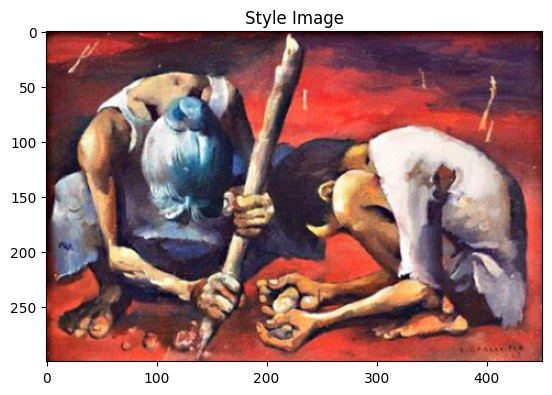

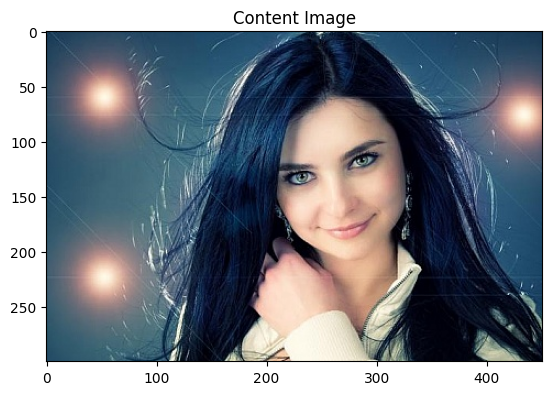

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
import torchvision.models as models
# Assuming FeatureExtractor is defined or imported

# Initialize the model

vgg19_model = models.vgg19(pretrained=False).features
model_path = '/content/drive/MyDrive/class2_model/vgg19_fined_tuned.pth'

vgg19_model.load_state_dict(torch.load(model_path))
vgg19_model.eval()

# Set the model to evaluation mode

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
cnn_normalization_median = torch.tensor([0.5176470875740051,0.4117647111415863 ,0.2705882489681244])
cnn_normalization_mean = torch.tensor([0.1748, -0.1010, -0.4108])
cnn_normalization_std = torch.tensor([1.1237, 1.0772, 1.0313])  # change std to dataset std
# cnn_normalization_std = torch.tensor([1.0237, 0.8972, 0.7916])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, median, std): # changed to median
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
       # self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.median = torch.tensor(median).view(-1,1,1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.median) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(vgg19_model, normalization_median, normalization_std, # changed to median
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_median, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in vgg19_model.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

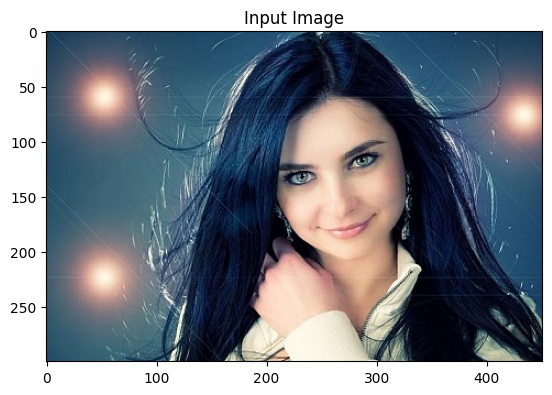

In [ ]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
!pip install LPIPS

In [ ]:
import lpips
lpips_loss = lpips.LPIPS(net='vgg').to(device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.055804 Content Loss: 0.038955 LPIPS Loss: 0.440921

run [100]:
Style Loss : 0.018151 Content Loss: 0.036721 LPIPS Loss: 0.336485

run [150]:
Style Loss : 0.007767 Content Loss: 0.035730 LPIPS Loss: 0.298064

run [200]:
Style Loss : 0.003762 Content Loss: 0.034228 LPIPS Loss: 0.269954

run [250]:
Style Loss : 0.002495 Content Loss: 0.032542 LPIPS Loss: 0.249506

run [300]:
Style Loss : 0.001877 Content Loss: 0.031573 LPIPS Loss: 0.238326

run [350]:
Style Loss : 0.001642 Content Loss: 0.030843 LPIPS Loss: 0.230111

run [400]:
Style Loss : 0.001460 Content Loss: 0.030356 LPIPS Loss: 0.223565



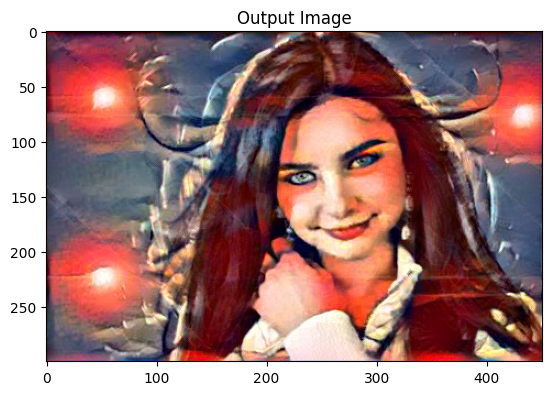

Final LPIPS Loss: 0.2216469794511795


In [ ]:
def run_style_transfer(vgg19_model, normalization_median, normalization_std,  # changed to median
                       content_img, style_img, input_img, num_steps=400,
                       style_weight=100000, content_weight= 0.015, lpips_weight= 0.1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(vgg19_model,
        normalization_median, normalization_std, style_img, content_img)  # changed to median

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    final_lpips_loss = 0.0  # added this

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            lpips_score = lpips_loss(input_img, content_img)

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score * lpips_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f} LPIPS Loss: {:4f}'.format(
                    style_score.item(), content_score.item(),lpips_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    final_lpips_loss = lpips_loss(input_img, content_img).item()

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img, final_lpips_loss

output, final_lpips_loss= run_style_transfer(vgg19_model, cnn_normalization_median, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

print (f"Final LPIPS Loss: {final_lpips_loss}")

plt.ioff()
plt.show()